In [1]:
# === CELL 1: Data Loading and Graph Construction ===
from Bio import SeqIO
import pandas as pd
import networkx as nx

# Load FASTA
fasta_path = "top_2000_sequences.faa"
fasta_records = list(SeqIO.parse(fasta_path, "fasta"))
print(f"Total protein sequences loaded: {len(fasta_records)}")

# Load STRING interactions
string_df = pd.read_csv("string_interactions.tsv", sep='\t')
G = nx.Graph()
for _, row in string_df.iterrows():
    G.add_edge(row["#node1"], row["node2"], weight=row["combined_score"])
print(f"✅ Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Preview
print("Sample edges:", list(G.edges(data=True))[:5])

# Load Biomni CSV
biomni_df = pd.read_csv("complete_vaccine_analysis_all_3257_proteins.csv").set_index("protein_id")
feature_cols = [
    "signal_peptide_strength", "number_of_tm_domains", "cysteine_content",
    "gravy_hydrophobicity", "protein_length", "molecular_weight_da",
    "instability_index", "isoelectric_point", "vaccine_score"
]
priority_map = {"Very Low": 0, "Low": 1, "Medium": 2, "High": 3}

for node in G.nodes:
    if node in biomni_df.index:
        row = biomni_df.loc[node]
        G.nodes[node]['features'] = row[feature_cols].values.astype(float)
        G.nodes[node]['priority'] = priority_map.get(row['priority'], -1)
    else:
        G.nodes[node]['features'] = None
        G.nodes[node]['priority'] = -1

/mmfs1/home/muhammad.kazim/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Total protein sequences loaded: 2000
✅ Graph loaded: 1607 nodes, 16315 edges
Sample edges: [('AEW84859.2', 'sdhA', {'weight': 0.409}), ('AEW84859.2', 'atpD', {'weight': 0.413}), ('AEW84859.2', 'AEW85750.1', {'weight': 0.452}), ('AEW84859.2', 'dnaJ', {'weight': 0.457}), ('AEW84859.2', 'AEW86571.1', {'weight': 0.467})]


In [2]:
# === CELL 2: Remap Node IDs ===
mapping_df = pd.read_csv("string_mapping.tsv", sep="\t")
mapping_df.columns = mapping_df.columns.str.replace('#', '')
string_to_fasta_map = dict(zip(mapping_df['preferredName'], mapping_df['queryItem']))
G_remapped = nx.relabel_nodes(G, string_to_fasta_map, copy=True)

# Attach features to remapped graph
missing = 0
for node in G_remapped.nodes:
    if node in biomni_df.index:
        row = biomni_df.loc[node]
        G_remapped.nodes[node]['features'] = row[feature_cols].values.astype(float)
        G_remapped.nodes[node]['priority'] = priority_map.get(row['priority'], -1)
    else:
        G_remapped.nodes[node]['features'] = None
        G_remapped.nodes[node]['priority'] = -1
        missing += 1

# Add isolated proteins
isolated_count = 0
for string_id, fasta_id in string_to_fasta_map.items():
    if fasta_id not in G_remapped:
        G_remapped.add_node(fasta_id)
        if fasta_id in biomni_df.index:
            row = biomni_df.loc[fasta_id]
            G_remapped.nodes[fasta_id]["features"] = row[feature_cols].values.astype(float)
            G_remapped.nodes[fasta_id]["priority"] = priority_map.get(row["priority"], -1)
        else:
            G_remapped.nodes[fasta_id]["features"] = None
            G_remapped.nodes[fasta_id]["priority"] = -1
        G_remapped.nodes[fasta_id]["isolated"] = True
        isolated_count += 1
print(f"✅ Added {isolated_count} isolated proteins to the graph.")

✅ Added 37 isolated proteins to the graph.


In [3]:
# === CELL 3: PyG Conversion & Edge Splitting ===
import torch
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling

sorted_nodes = list(G_remapped.nodes)
node_to_idx = {node: i for i, node in enumerate(sorted_nodes)}
features, labels = [], []
for node in sorted_nodes:
    data = G_remapped.nodes[node]
    feat = data.get("features", [0.0]*len(feature_cols))
    features.append(feat)
    labels.append(data.get("priority", -1))

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)
edge_index = torch.tensor([
    [node_to_idx[u], node_to_idx[v]] for u, v in G_remapped.edges()
], dtype=torch.long).t().contiguous()

pyg_graph = Data(x=x, edge_index=edge_index, y=y)
pyg_graph.node_names = sorted_nodes

# Edge splitting
torch.manual_seed(42)
num_edges = edge_index.size(1)
perm = torch.randperm(num_edges)
split = int(0.9 * num_edges)
train_pos = edge_index[:, perm[:split]]
test_pos = edge_index[:, perm[split:]]
test_neg = negative_sampling(edge_index=edge_index, num_nodes=x.size(0), num_neg_samples=test_pos.size(1))
print(f"✅ PyG graph ready. Nodes: {x.size(0)}, Edges: {edge_index.size(1)}")


✅ PyG graph ready. Nodes: 1644, Edges: 16315


/var/tmp/pbs.421069.bright04/ipykernel_1183483/2007925081.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x = torch.tensor(features, dtype=torch.float)


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# GNN-based encoder
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Dot-product link predictor
class LinkPredictor(nn.Module):
    def forward(self, z, edge_index):
        # z: node embeddings, edge_index: [2, num_edges]
        src, dst = edge_index
        return (z[src] * z[dst]).sum(dim=-1)  # dot product


In [6]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score

# Hyperparameters
in_channels = pyg_graph.num_node_features
hidden_channels = 64
epochs = 50
lr = 0.01

# Models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(in_channels, hidden_channels).to(device)
predictor = LinkPredictor().to(device)

# Optimizer
optimizer = optim.Adam(list(model.parameters()) + list(predictor.parameters()), lr=lr)

# Move data to device
x = pyg_graph.x.to(device)
edge_index = pyg_graph.edge_index.to(device)
train_pos = train_pos.to(device)
test_pos = test_pos.to(device)
test_neg = test_neg.to(device)

# Training loop
for epoch in range(epochs):
    model.train()
    predictor.train()

    # Get node embeddings
    z = model(x, edge_index)

    # Positive samples
    pos_score = predictor(z, train_pos)
    pos_label = torch.ones(pos_score.size(), device=device)

    # Negative samples (same number as pos)
    train_neg = negative_sampling(edge_index, pyg_graph.num_nodes, train_pos.size(1)).to(device)
    neg_score = predictor(z, train_neg)
    neg_label = torch.zeros(neg_score.size(), device=device)

    # Combine
    score = torch.cat([pos_score, neg_score])
    label = torch.cat([pos_label, neg_label])

    loss = F.binary_cross_entropy_with_logits(score, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Eval
    model.eval()
    z = model(x, edge_index)
    with torch.no_grad():
        test_score_pos = torch.sigmoid(predictor(z, test_pos))
        test_score_neg = torch.sigmoid(predictor(z, test_neg))

        test_scores = torch.cat([test_score_pos, test_score_neg])
        test_labels = torch.cat([
            torch.ones(test_score_pos.size(0)),
            torch.zeros(test_score_neg.size(0))
        ])

        auc = roc_auc_score(test_labels.cpu(), test_scores.cpu())

    print(f"📉 Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Test AUC: {auc:.4f}")


📉 Epoch 1/50, Loss: 3232642816.0000, Test AUC: 0.5080
📉 Epoch 2/50, Loss: 830998016.0000, Test AUC: 0.5003
📉 Epoch 3/50, Loss: 612604608.0000, Test AUC: 0.5000
📉 Epoch 4/50, Loss: 825224128.0000, Test AUC: 0.5000
📉 Epoch 5/50, Loss: 815213248.0000, Test AUC: 0.5003
📉 Epoch 6/50, Loss: 618957184.0000, Test AUC: 0.5074
📉 Epoch 7/50, Loss: 390255456.0000, Test AUC: 0.5172
📉 Epoch 8/50, Loss: 265088096.0000, Test AUC: 0.5193
📉 Epoch 9/50, Loss: 220268368.0000, Test AUC: 0.5202
📉 Epoch 10/50, Loss: 210547104.0000, Test AUC: 0.5205
📉 Epoch 11/50, Loss: 202781136.0000, Test AUC: 0.5193
📉 Epoch 12/50, Loss: 185127040.0000, Test AUC: 0.5193
📉 Epoch 13/50, Loss: 158309232.0000, Test AUC: 0.5211
📉 Epoch 14/50, Loss: 128195176.0000, Test AUC: 0.5227
📉 Epoch 15/50, Loss: 108156768.0000, Test AUC: 0.5236
📉 Epoch 16/50, Loss: 98806424.0000, Test AUC: 0.5242
📉 Epoch 17/50, Loss: 92486416.0000, Test AUC: 0.5251
📉 Epoch 18/50, Loss: 89618448.0000, Test AUC: 0.5263
📉 Epoch 19/50, Loss: 86897272.0000, Tes

In [7]:
# === CELL 4: Compute Embeddings & Identify Isolated Nodes ===
model.eval()
with torch.no_grad():
    z = model(x, edge_index)  # Get final node embeddings

# Identify isolated nodes from G_remapped
isolated_nodes = [n for n, d in G_remapped.nodes(data=True) if d.get("isolated") is True]
connected_nodes = [n for n in G_remapped.nodes if n not in isolated_nodes]

print(f"Total isolated nodes: {len(isolated_nodes)}")
print(f"Total connected nodes: {len(connected_nodes)}")


Total isolated nodes: 37
Total connected nodes: 1607


In [8]:
# === CELL 5: Build Candidate Edge List ===
import itertools

# Mapping from node name to PyG index
node_to_idx = {name: i for i, name in enumerate(pyg_graph.node_names)}
idx_to_node = {i: name for name, i in node_to_idx.items()}

# Build edge candidates: (a) isolated ↔ connected, (b) isolated ↔ isolated
candidate_edges = []

# Isolated–Connected
for iso in isolated_nodes:
    for conn in connected_nodes:
        u, v = node_to_idx[iso], node_to_idx[conn]
        if not G_remapped.has_edge(iso, conn):
            candidate_edges.append((u, v))

# Isolated–Isolated (upper triangle only to avoid duplicates)
for u, v in itertools.combinations(isolated_nodes, 2):
    idx_u, idx_v = node_to_idx[u], node_to_idx[v]
    if not G_remapped.has_edge(u, v):
        candidate_edges.append((idx_u, idx_v))

print(f"✅ Total candidate new edges: {len(candidate_edges)}")


✅ Total candidate new edges: 60125


In [9]:
# === CELL 6: Score Candidate Edges and Filter Top Predictions ===
from torch.nn.functional import sigmoid

# Convert to tensor
candidate_edge_tensor = torch.tensor(candidate_edges, dtype=torch.long).t().contiguous().to(device)

# Predict scores
model.eval()
predictor.eval()
with torch.no_grad():
    scores = predictor(z, candidate_edge_tensor)
    probs = sigmoid(scores)

# Apply threshold
threshold = 0.90
mask = probs >= threshold
filtered_edges = candidate_edge_tensor[:, mask]
filtered_probs = probs[mask]

# Keep top 1000 by probability (if more than 1000)
top_k = 1000
if filtered_edges.size(1) > top_k:
    topk_vals, topk_idx = torch.topk(filtered_probs, top_k)
    final_edges = filtered_edges[:, topk_idx]
    final_probs = topk_vals
else:
    final_edges = filtered_edges
    final_probs = filtered_probs

print(f"✅ Final predicted links selected: {final_edges.size(1)}")


✅ Final predicted links selected: 1000


In [10]:
# === CELL 7: Analyze Priority Class Combinations ===
from collections import Counter
import pandas as pd

# Reverse map from index to protein name
idx_to_node = {i: name for i, name in enumerate(pyg_graph.node_names)}

# Get priority class of each node
priority_dict = {name: G_remapped.nodes[name].get("priority", -1) for name in G_remapped.nodes}

# Count class combinations
class_pair_counter = Counter()
pair_types = []  # To track Isolated–Isolated or Isolated–Connected

for i in range(final_edges.size(1)):
    u_idx, v_idx = final_edges[0, i].item(), final_edges[1, i].item()
    u_name, v_name = idx_to_node[u_idx], idx_to_node[v_idx]
    u_priority, v_priority = priority_dict[u_name], priority_dict[v_name]
    
    # Sort classes for consistent keys (e.g., (2, 3) same as (3, 2))
    pair_key = tuple(sorted((u_priority, v_priority)))
    class_pair_counter[pair_key] += 1

# Convert to DataFrame
priority_labels = ["Very Low", "Low", "Medium", "High"]
n_classes = 4
table = pd.DataFrame(0, index=priority_labels, columns=priority_labels)

for (a, b), count in class_pair_counter.items():
    a_label, b_label = priority_labels[a], priority_labels[b]
    table.loc[a_label, b_label] += count
    if a != b:
        table.loc[b_label, a_label] += count  # Symmetric for heatmap

import IPython.display as disp
disp.display(table)


,Very Low,Low,Medium,High
Very Low,75,55,208,215
Low,55,0,125,152
Medium,208,125,66,89
High,215,152,89,15


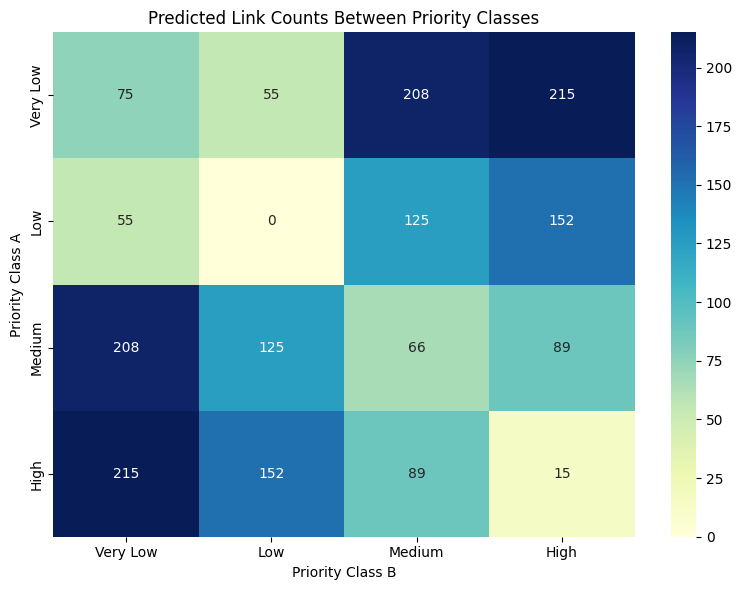

In [11]:
# === CELL 8: Plot Heatmap of Priority Class Links ===
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(table, annot=True, fmt='d', cmap="YlGnBu", cbar=True)
plt.title("Predicted Link Counts Between Priority Classes")
plt.xlabel("Priority Class B")
plt.ylabel("Priority Class A")
plt.tight_layout()
plt.show()
